In [1]:
# ! pip install --upgrade jax jaxlib
# ! pip install flax
# ! pip install einops

In [2]:
import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax import jacfwd, jacrev, grad, jvp

import flax.linen as nn
from einops import rearrange

import matplotlib.pyplot as plt

# Neural Conservation Laws

Putzing around with some results of the paper _Neural Conservation Laws: A Divergence-Free Perspective_ (NeurIPS 2022) [\[arXiv\]](https://arxiv.org/abs/2210.01741).

Start by defining an arbitrary vector field $\mathbb R^n \rightarrow \mathbb R^n$.

In [3]:
d = 2  # Number of dimensions

In [4]:
class b(nn.Module):
    """ Arbitrary vector field R^d -> R^d
    """
    
    @nn.compact
    def __call__(self, x, d_hidden=128):
        x = nn.Dense(d)(x)
        x = nn.gelu(x)
        x = nn.Dense(d_hidden)(x)
        x = nn.gelu(x)
        x = nn.Dense(d_hidden)(x)
        x = nn.gelu(x)
        x = nn.Dense(d)(x)
        return x
    
model = b()

key1, key2 = jax.random.split(jax.random.PRNGKey(34))
x = jax.random.normal(key1, (d,))
params = model.init(key2, x)

def b_for_jac(x):
    """ Helper function
    """
    return model.apply(params, x)

In [5]:
## Plot options 

# Divergence plot mesh

n_grid = 100
extent = 1
x_ary = jnp.linspace(-extent, extent, n_grid)
x_mesh = rearrange(jnp.array(jnp.meshgrid(x_ary, x_ary)).T, "x y d -> (x y) d")

# Quiver plot mesh

n_grid_quiver = 20
x_ary_quiver = jnp.linspace(-extent, extent, n_grid_quiver)
x_mesh_quiver = rearrange(jnp.array(jnp.meshgrid(x_ary_quiver, x_ary_quiver)).T, "x y d -> (x y) d")

Plot the arbitrary field and its divergence.

Text(0.5, 1.0, '$\\operatorname{div}b(\\vec x)$')

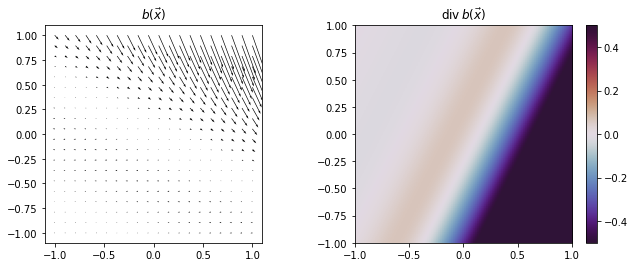

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# Quiver plot

U, V = vmap(b_for_jac)(x_mesh_quiver).T
X, Y = x_mesh_quiver.T
ax[0].quiver(X, Y, U, V)
ax[0].set_aspect(1.)
ax[0].set_title(r"$b(\vec x)$")

# Divergence

im = ax[1].imshow(rearrange(jnp.trace(vmap(jacfwd(b_for_jac))(x_mesh), axis1=1, axis2=2), "(x y) -> x y", x=n_grid), vmin=-0.5, vmax=0.5, cmap='twilight_shifted', extent=[-extent,extent,-extent,extent])
fig.colorbar(im, ax=ax[1])
ax[1].set_title(r"$\operatorname{div}b(\vec x)$")

Now define a construction for a divergence-less field $v(\vec x)$.

In [7]:
def A(x):
    """ Antisymmetric matrix R^d -> R^(d x d); Eq. (7) of 2210.06564
    """
    Jb = jacfwd(b_for_jac)(x)
    A = Jb - Jb.T
    return A

def v(x):
    """ Target divergenceless field R^(d x d) -> R^d; Eq. (4) of 2210.06564
    """
    return jnp.trace(jacfwd(A)(x), axis1=1, axis2=2)

In [8]:
# Evaluate target field at a given point
v(x)

DeviceArray([ 0.28859383, -0.14629462], dtype=float32)

In [9]:
# Check that divergence of v vanishes at a given point
jnp.trace(jacfwd(v)(x))

DeviceArray(0., dtype=float32)

Plot the target field of interest and its divergence.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# Quiver plot

U, V = vmap(v)(x_mesh_quiver).T
X, Y = x_mesh_quiver.T
ax[0].quiver(X, Y, U, V)
ax[0].set_aspect(1.)
ax[0].set_title(r"$b(\vec x)$")

# Divergence

im = ax[1].imshow(rearrange(jnp.trace(vmap(jacfwd(v))(x_mesh), axis1=1, axis2=2), "(x y) -> x y", x=n_grid), vmin=-0.5, vmax=0.5, cmap='twilight_shifted', extent=[-extent,extent,-extent,extent])
fig.colorbar(im, ax=ax[1])
ax[1].set_title(r"$\operatorname{div}b(\vec x)$")

We have a field with vanishing divergence!